## This script was developed for:
#### Zhu, F. and B.E.J. Rose. (2022). Multiple Equilibria in a Coupled Climate-Carbon Model. Journal of Climate. DOI: 10.1175/JCLI-D-21-0984.1

Author of the script: *Fangze Zhu*

University at Albany, State University of New York (SUNY)

In [9]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
from numpy import dtype

mitdir = '/nfs/home11/grad/2017/fz172169/MITgcm/utils/python/MITgcmutils'
os.chdir(mitdir)
import MITgcmutils as mit

csdir = '/nfs/home11/grad/2017/fz172169/Documents/my_scripts'
os.chdir(csdir)
from cs import zonalKernel
from cs import zonalAvg

In [10]:
exp_warm = [#'warmT293_50',
            #'warmT293_415',
            #'warm_150',
            'warm_test16_1050',
            'warm_test16_1100',
            'warm_test16_1150',
            'warm_test16_1200',
            'warm_test16_1250',
            ]
exp_cold = ['cold_800',
            'cold_850',
            'cold_900',
            'cold_950',
            'cold_1000',
            ]
exp_waterbelt = ['waterbelt_350',
                 'waterbelt_400',
                 #'waterbelt_410',
                 #'waterbelt_420',
                 #'waterbelt_430',
                 #'waterbelt_440',
                 'waterbelt_450',
                 'waterbelt_500',
                 'waterbelt_550',
                 ]

In [11]:
dir = '/nfs/roselab_rit/mitgcm_run'
rundir = os.path.join(dir, 'kernel')
datadir = '/nfs/roselab_rit/mitgcm_output/kernel_data'

grid_atm = mit.rdmnc(os.path.join(dir,'radCO2_warm_pco2','out/Cpl1/GridAtm/grid.*'))   # Read the grid
global_area = np.sum(grid_atm['rA'])
X = len(grid_atm['X'])
Y = len(grid_atm['Y'])
Z = len(grid_atm['Z'])
print(grid_atm['Z'])

[95000. 77500. 50000. 25000.  7500.]


In [12]:
def write_kernel(filename, varname, units, varout):

    # open a netCDF file to write
    ncout = Dataset(filename, 'w', format='NETCDF4')

    # define axis size
    ncout.createDimension('time', None)  # unlimited
    if varout.ndim == 4:
        if 'T' in varname:
            ncout.createDimension('lev', Z)
        if 'Q' in varname:
            ncout.createDimension('lev', Z-1)
    ncout.createDimension('lat', Y)
    ncout.createDimension('lon', X)
    
    # create time axis
    time = ncout.createVariable('time', dtype('double').char, ('time',))
    time.long_name = 'month'

    # create vertical axis
    if varout.ndim == 4:
        lev = ncout.createVariable('lev', dtype('double').char, ('lev',))
        lev.long_name = 'vertical coordinate'
        lev.units = 'hPa'

    # create latitude axis
    lat = ncout.createVariable('lat', dtype('double').char, ('lat',))
    lat.long_name = 'latitude'
    lat.units = 'degrees_north'

    # create longitude axis
    lon = ncout.createVariable('lon', dtype('double').char, ('lon',))
    lon.long_name = 'longitude'
    lon.units = 'degrees_east'

    # create variable array
    if varout.ndim == 4:
        vout = ncout.createVariable(varname, dtype('double').char, ('time', 'lev', 'lat', 'lon',))
    else:
        vout = ncout.createVariable(varname, dtype('double').char, ('time', 'lat', 'lon',))
    vout.units = units

    # copy axis from original dataset
    time[:] = np.arange(varout.shape[0])+1
    if varout.ndim == 4:
        if 'T' in varname:
            lev[:] = grid_atm['Z'][0:Z]/100.
        if 'Q' in varname:
            lev[:] = grid_atm['Z'][0:Z-1]/100.
    lat[:] = grid_atm['Y']
    lon[:] = grid_atm['X']
    vout[:] = varout

    # close files
    ncout.close()

In [13]:
def read_kernel(filename, varname):
    fname = filename
    ncin = Dataset(fname, 'r', format='NETCDF4')
    vin = ncin.variables[varname]
    return vin[:]

In [14]:
def calculate_kernel_T(state, deltaT, var, band):
    kernel = np.zeros((12,Z,Y,X))
    kernel_CLR = np.zeros((12,Z,Y,X))
    ctrdir = os.path.join(rundir, 'kernel_ctr_'+state)
    for k in range(Z):
        kerdir = os.path.join(rundir, 'kernel_'+var+str(k+1)+'_'+state)
        #nperiods = len(glob(kerdir+'/out/Cpl*'))
        nperiods = 360
        deltaR = np.zeros((nperiods,Y,X))
        deltaR_CLR = np.zeros((nperiods,Y,X))
        for n in range(nperiods):
            DiagAim_ctr = mit.rdmnc(os.path.join(ctrdir, 'out', 'Cpl'+str(n+2), 'Atm/DiagAim.*'))
            DiagAim_ker = mit.rdmnc(os.path.join(kerdir, 'out', 'Cpl'+str(n+1), 'Atm/DiagAim.*'))
            if band == 'LW':
                deltaR[n,:,:] = DiagAim_ker['OLR'] - DiagAim_ctr['OLR']
                deltaR_CLR[n,:,:] = DiagAim_ker['OLRCLR'] - DiagAim_ctr['OLRCLR']
            elif band == 'SW':
                deltaR[n,:,:] = DiagAim_ker['TSR'] - DiagAim_ctr['TSR']
                deltaR_CLR[n,:,:] = DiagAim_ker['TSRCLR'] - DiagAim_ctr['TSRCLR']
        deltaR.resize(12,30,Y,X)
        deltaR_CLR.resize(12,30,Y,X)
        kernel[:,k,:,:] = np.mean(deltaR/deltaT, axis=1)
        kernel_CLR[:,k,:,:] = np.mean(deltaR_CLR/deltaT, axis=1)
    # Save kernels
    try:
        os.mkdir(os.path.join(datadir,'kernel',state))
        os.chdir(os.path.join(datadir,'kernel',state))
    except:
        os.chdir(os.path.join(datadir,'kernel',state))
    if band == 'LW':
        write_kernel(filename='kernel_'+var+'_'+band+'_'+state+'.nc', 
                     varname='kernel_'+var+'_'+band, 
                     units='W/m2/K per 100hPa', 
                     varout=-kernel)
        write_kernel(filename='kernel_'+var+'_'+band+'_CLR_'+state+'.nc', 
                     varname='kernel_'+var+'_'+band+'_CLR', 
                     units='W/m2/K per 100hPa', 
                     varout=-kernel_CLR)
    elif band == 'SW':
        write_kernel(filename='kernel_'+var+'_'+band+'_'+state+'.nc', 
                     varname='kernel_'+var+'_'+band, 
                     units='W/m2/K per 100hPa', 
                     varout=kernel)
        write_kernel(filename='kernel_'+var+'_'+band+'_CLR_'+state+'.nc', 
                     varname='kernel_'+var+'_'+band+'_CLR', 
                     units='W/m2/K per 100hPa', 
                     varout=kernel_CLR)

In [15]:
def calculate_kernel_Q(state, var, band, fraction):
    kernel = np.zeros((12,Z-1,Y,X))
    kernel_CLR = np.zeros((12,Z-1,Y,X))
    ctrdir = os.path.join(rundir, 'kernel_ctr_'+state)
    for k in range(Z-1):
        kerdir = os.path.join(rundir, 'kernel_'+var+str(k+1)+'_'+state)
        #nperiods = len(glob(kerdir+'/out/Cpl*'))
        nperiods = 360
        deltaR = np.zeros((nperiods,Y,X))
        deltaR_CLR = np.zeros((nperiods,Y,X))
        deltaQ = np.zeros((nperiods,Y,X))
        for n in range(nperiods):
            DiagAim_ctr = mit.rdmnc(os.path.join(ctrdir, 'out', 'Cpl'+str(n+2), 'Atm/DiagAim.*'))
            DiagAim_ker = mit.rdmnc(os.path.join(kerdir, 'out', 'Cpl'+str(n+1), 'Atm/DiagAim.*'))
            if band == 'LW':
                deltaR[n,:,:] = DiagAim_ker['OLR'] - DiagAim_ctr['OLR']
                deltaR_CLR[n,:,:] = DiagAim_ker['OLRCLR'] - DiagAim_ctr['OLRCLR']
            elif band == 'SW':
                deltaR[n,:,:] = DiagAim_ker['TSR'] - DiagAim_ctr['TSR']
                deltaR_CLR[n,:,:] = DiagAim_ker['TSRCLR'] - DiagAim_ctr['TSRCLR']
            DiagAtmTave_ctr = mit.rdmnc(os.path.join(ctrdir, 'out', 'Cpl'+str(n+2), 'Atm/DiagAtmTave.*'))
            deltaQ[n,:,:] = DiagAtmTave_ctr['SALT'][:,k,:,:]*fraction
        deltaR.resize(12,30,Y,X)
        deltaR_CLR.resize(12,30,Y,X)
        deltaQ.resize(12,30,Y,X)
        kernel[:,k,:,:] = np.mean(deltaR/deltaQ, axis=1)
        kernel_CLR[:,k,:,:] = np.mean(deltaR_CLR/deltaQ, axis=1)
    # Save kernels
    try:
        os.mkdir(os.path.join(datadir,'kernel',state))
        os.chdir(os.path.join(datadir,'kernel',state))
    except:
        os.chdir(os.path.join(datadir,'kernel',state))
    if band == 'LW':
        write_kernel(filename='kernel_'+var+'_'+band+'_'+state+'.nc', 
                     varname='kernel_'+var+'_'+band, 
                     units='W/m2/K per 100hPa', 
                     varout=-kernel)
        write_kernel(filename='kernel_'+var+'_'+band+'_CLR_'+state+'.nc', 
                     varname='kernel_'+var+'_'+band+'_CLR', 
                     units='W/m2/K per 100hPa', 
                     varout=-kernel_CLR)
    elif band == 'SW':
        write_kernel(filename='kernel_'+var+'_'+band+'_'+state+'.nc', 
                     varname='kernel_'+var+'_'+band, 
                     units='W/m2/K per 100hPa', 
                     varout=kernel)
        write_kernel(filename='kernel_'+var+'_'+band+'_CLR_'+state+'.nc', 
                     varname='kernel_'+var+'_'+band+'_CLR', 
                     units='W/m2/K per 100hPa', 
                     varout=kernel_CLR)

In [16]:
def calculate_kernel_surfT(state, deltaT, var, band):
    ctrdir = os.path.join(rundir, 'kernel_ctr_'+state)
    kerdir = os.path.join(rundir, 'kernel_'+var+'_'+state)
    #nperiods = len(glob(kerdir+'/out/Cpl*'))
    nperiods = 360
    deltaR = np.zeros((nperiods,Y,X))
    deltaR_CLR = np.zeros((nperiods,Y,X))
    for n in range(nperiods):
        DiagAim_ctr = mit.rdmnc(os.path.join(ctrdir, 'out', 'Cpl'+str(n+2), 'Atm/DiagAim.*'))
        DiagAim_ker = mit.rdmnc(os.path.join(kerdir, 'out', 'Cpl'+str(n+1), 'Atm/DiagAim.*'))
        if band == 'LW':
            deltaR[n,:,:] = DiagAim_ker['OLR'] - DiagAim_ctr['OLR']
            deltaR_CLR[n,:,:] = DiagAim_ker['OLRCLR'] - DiagAim_ctr['OLRCLR']
        elif band == 'SW':
            deltaR[n,:,:] = DiagAim_ker['TSR'] - DiagAim_ctr['TSR']
            deltaR_CLR[n,:,:] = DiagAim_ker['TSRCLR'] - DiagAim_ctr['TSRCLR']
    deltaR.resize(12,30,Y,X)
    deltaR_CLR.resize(12,30,Y,X)
    kernel = np.mean(deltaR/deltaT, axis=1)
    kernel_CLR = np.mean(deltaR_CLR/deltaT, axis=1)
    # Save kernels
    try:
        os.mkdir(os.path.join(datadir,'kernel',state))
        os.chdir(os.path.join(datadir,'kernel',state))
    except:
        os.chdir(os.path.join(datadir,'kernel',state))
    if band == 'LW':
        write_kernel(filename='kernel_'+var+'_'+band+'_'+state+'.nc', 
                     varname='kernel_'+var+'_'+band, 
                     units='W/m2/K', 
                     varout=-kernel)
        write_kernel(filename='kernel_'+var+'_'+band+'_CLR_'+state+'.nc', 
                     varname='kernel_'+var+'_'+band+'_CLR', 
                     units='W/m2/K', 
                     varout=-kernel_CLR)
    elif band == 'SW':
        write_kernel(filename='kernel_'+var+'_'+band+'_'+state+'.nc', 
                     varname='kernel_'+var+'_'+band, 
                     units='W/m2/K', 
                     varout=kernel)
        write_kernel(filename='kernel_'+var+'_'+band+'_CLR_'+state+'.nc', 
                     varname='kernel_'+var+'_'+band+'_CLR', 
                     units='W/m2/K', 
                     varout=kernel_CLR)

In [17]:
def calculate_kernel_ALB(state, var, band):
    ctrdir = os.path.join(rundir, 'kernel_ctr_'+state)
    kerdir = os.path.join(rundir, 'kernel_'+var+'_'+state)
    #nperiods = len(glob(kerdir+'/out/Cpl*'))
    nperiods = 360
    deltaR = np.zeros((nperiods,Y,X))
    deltaR_CLR = np.zeros((nperiods,Y,X))
    delta_ALB = np.zeros((nperiods,Y,X))
    for n in range(nperiods):
        DiagAim_ctr = mit.rdmnc(os.path.join(ctrdir, 'out', 'Cpl'+str(n+2), 'Atm/DiagAim.*'))
        DiagAim_ker = mit.rdmnc(os.path.join(kerdir, 'out', 'Cpl'+str(n+1), 'Atm/DiagAim.*'))
        if band == 'LW':
            deltaR[n,:,:] = DiagAim_ker['OLR'] - DiagAim_ctr['OLR']
            deltaR_CLR[n,:,:] = DiagAim_ker['OLRCLR'] - DiagAim_ctr['OLRCLR']
        elif band == 'SW':
            deltaR[n,:,:] = DiagAim_ker['TSR'] - DiagAim_ctr['TSR']
            deltaR_CLR[n,:,:] = DiagAim_ker['TSRCLR'] - DiagAim_ctr['TSRCLR']
        #delta_ALB[n,:,:] = DiagAim_ctr['ALBVISDF']*0.01
        delta_ALB[n,:,:] = 0.01
    deltaR.resize(12,30,Y,X)
    deltaR_CLR.resize(12,30,Y,X)
    delta_ALB.resize(12,30,Y,X)
    kernel = np.mean(deltaR/delta_ALB, axis=1)
    kernel_CLR = np.mean(deltaR_CLR/delta_ALB, axis=1)
    # Save kernels
    try:
        os.mkdir(os.path.join(datadir,'kernel',state))
        os.chdir(os.path.join(datadir,'kernel',state))
    except:
        os.chdir(os.path.join(datadir,'kernel',state))
    if band == 'LW':
        write_kernel(filename='kernel_'+var+'_'+band+'_'+state+'.nc', 
                     varname='kernel_'+var+'_'+band, 
                     units='W/m2/K', 
                     varout=-kernel)
        write_kernel(filename='kernel_'+var+'_'+band+'_CLR_'+state+'.nc', 
                     varname='kernel_'+var+'_'+band+'_CLR', 
                     units='W/m2/K', 
                     varout=-kernel_CLR)
    elif band == 'SW':
        write_kernel(filename='kernel_'+var+'_'+band+'_'+state+'.nc', 
                     varname='kernel_'+var+'_'+band, 
                     units='W/m2/K', 
                     varout=kernel)
        write_kernel(filename='kernel_'+var+'_'+band+'_CLR_'+state+'.nc', 
                     varname='kernel_'+var+'_'+band+'_CLR', 
                     units='W/m2/K', 
                     varout=kernel_CLR)

In [18]:
def calculate_kernel_CO2(state, var, band):
    ctrdir = os.path.join(rundir, 'kernel_ctr_'+state)
    kerdir = os.path.join(rundir, 'kernel_'+var+'_'+state)
    #nperiods = len(glob(kerdir+'/out/Cpl*'))
    nperiods = 360
    deltaR = np.zeros((nperiods,Y,X))
    deltaR_CLR = np.zeros((nperiods,Y,X))
    delta_CO2 = np.zeros((nperiods,Y,X))
    for n in range(nperiods):
        DiagAim_ctr = mit.rdmnc(os.path.join(ctrdir, 'out', 'Cpl'+str(n+2), 'Atm/DiagAim.*'))
        DiagAim_ker = mit.rdmnc(os.path.join(kerdir, 'out', 'Cpl'+str(n+1), 'Atm/DiagAim.*'))
        if band == 'LW':
            deltaR[n,:,:] = DiagAim_ker['OLR'] - DiagAim_ctr['OLR']
            deltaR_CLR[n,:,:] = DiagAim_ker['OLRCLR'] - DiagAim_ctr['OLRCLR']
        elif band == 'SW':
            deltaR[n,:,:] = DiagAim_ker['TSR'] - DiagAim_ctr['TSR']
            deltaR_CLR[n,:,:] = DiagAim_ker['TSRCLR'] - DiagAim_ctr['TSRCLR']
        pCO2 = read_kernel(filename=glob(os.path.join(kerdir, 'out', 'Cpl'+str(n+1), 'MON/pCO2StDiag.*'))[0],
                           varname='aim_pCO2_ave')
        delta_CO2[n,:,:] = np.squeeze(pCO2)*0.01
    deltaR.resize(12,30,Y,X)
    deltaR_CLR.resize(12,30,Y,X)
    delta_CO2.resize(12,30,Y,X)
    kernel = np.mean(deltaR/delta_CO2, axis=1)
    kernel_CLR = np.mean(deltaR_CLR/delta_CO2, axis=1)
    # Save kernels
    try:
        os.mkdir(os.path.join(datadir,'kernel',state))
        os.chdir(os.path.join(datadir,'kernel',state))
    except:
        os.chdir(os.path.join(datadir,'kernel',state))
    if band == 'LW':
        write_kernel(filename='kernel_'+var+'_'+band+'_'+state+'.nc', 
                     varname='kernel_'+var+'_'+band, 
                     units='W/m2/ppm', 
                     varout=-kernel)
        write_kernel(filename='kernel_'+var+'_'+band+'_CLR_'+state+'.nc', 
                     varname='kernel_'+var+'_'+band+'_CLR', 
                     units='W/m2/ppm', 
                     varout=-kernel_CLR)
    elif band == 'SW':
        write_kernel(filename='kernel_'+var+'_'+band+'_'+state+'.nc', 
                     varname='kernel_'+var+'_'+band, 
                     units='W/m2/ppm', 
                     varout=kernel)
        write_kernel(filename='kernel_'+var+'_'+band+'_CLR_'+state+'.nc', 
                     varname='kernel_'+var+'_'+band+'_CLR', 
                     units='W/m2/ppm', 
                     varout=kernel_CLR)

In [19]:
def annual_kernel(state, var, band):
    os.chdir(os.path.join(datadir,'kernel',state))
    kernel = read_kernel(filename='kernel_'+var+'_'+band+'_'+state+'.nc', 
                         varname='kernel_'+var+'_'+band)
    kernel_CLR = read_kernel(filename='kernel_'+var+'_'+band+'_CLR_'+state+'.nc', 
                             varname='kernel_'+var+'_'+band+'_CLR')
    
    drF = grid_atm['drF']
    if var == 'T':
        kernel_w = np.zeros((12,Z,Y,X))
        kernel_CLR_w = np.zeros((12,Z,Y,X))
        for k in range(Z):
            kernel_w[:,k,:,:] = kernel[:,k,:,:]/(drF[k]*1E-4)
            kernel_CLR_w[:,k,:,:] = kernel_CLR[:,k,:,:]/(drF[k]*1E-4)
        ann_kernel = np.mean(kernel_w, axis=0)
        ann_kernel_CLR = np.mean(kernel_CLR_w, axis=0)
    elif var == 'Q':
        kernel_w = np.zeros((12,Z-1,Y,X))
        kernel_CLR_w = np.zeros((12,Z-1,Y,X))
        for k in range(Z-1):
            kernel_w[:,k,:,:] = kernel[:,k,:,:]/(drF[k]*1E-4)
            kernel_CLR_w[:,k,:,:] = kernel_CLR[:,k,:,:]/(drF[k]*1E-4)        
        ann_kernel = np.mean(kernel_w, axis=0)
        ann_kernel_CLR = np.mean(kernel_CLR_w, axis=0)
    else:
        ann_kernel = np.mean(kernel, axis=0)
        ann_kernel_CLR = np.mean(kernel_CLR, axis=0)
    return ann_kernel, ann_kernel_CLR

In [20]:
def plot_annual_kernel(state, var, band):
    ann_kernel, ann_kernel_CLR = annual_kernel(state, var, band)

    ny = 60
    kernel, ylat, areazon = zonalKernel(grid_atm,ny)    
    fig, ax = plt.subplots(1,2, figsize=(18,9))
    if var == 'T':
        ann_kernel_zonal = np.zeros((Z,ny))
        ann_kernel_CLR_zonal = np.zeros((Z,ny))  
        lev = grid_atm['Z'][0:Z]/100.
        for k in range(Z):
            ann_kernel_zonal[k,:] = zonalAvg(ann_kernel[k,:,:],kernel)
            ann_kernel_CLR_zonal[k,:] = zonalAvg(ann_kernel_CLR[k,:,:],kernel)
    if var == 'Q':        
        ann_kernel_zonal = np.zeros((Z-1,ny))
        ann_kernel_CLR_zonal = np.zeros((Z-1,ny))  
        lev = grid_atm['Z'][0:Z-1]/100.
        for k in range(Z-1):
            ann_kernel_zonal[k,:] = zonalAvg(ann_kernel[k,:,:],kernel)
            ann_kernel_CLR_zonal[k,:] = zonalAvg(ann_kernel_CLR[k,:,:],kernel)
            
    y, z = np.meshgrid(ylat, lev)
    c1=ax[0].contourf(y, z, ann_kernel_zonal)
    c2=ax[1].contourf(y, z, ann_kernel_CLR_zonal)

    cbar1 = fig.colorbar(c1, ax=ax[0], orientation='horizontal')
    cbar1.ax.tick_params(labelsize=15) 
    cbar2 = fig.colorbar(c2, ax=ax[1], orientation='horizontal')
    cbar2.ax.tick_params(labelsize=15) 

    for axes in ax:
        axes.invert_yaxis()
        axes.set_xlabel('Latitude', fontsize=16)   
        axes.set_ylabel('hPa', fontsize=16)
        axes.set_xlim(-90,90)
        axes.tick_params(axis='both', which='major', labelsize=15)
    ax[0].set_title('Kernel_'+var+'_'+band+'_'+state, fontsize=18)
    ax[1].set_title('Kernel_'+var+'_'+band+'_CLR_'+state, fontsize=18)

In [21]:
def plot_annual_kernel_1D(state, var, band):
    ann_kernel, ann_kernel_CLR = annual_kernel(state, var, band)
    
    ny = 60
    fig, ax = plt.subplots(1,2, figsize=(18,4))
    kernel, ylat, areazon = zonalKernel(grid_atm,ny)
    ann_kernel_zonal = zonalAvg(ann_kernel,kernel)
    ann_kernel_CLR_zonal = zonalAvg(ann_kernel_CLR,kernel)
    
    ax[0].plot(ylat, ann_kernel_zonal)
    ax[1].plot(ylat, ann_kernel_CLR_zonal)

    for axes in ax:
        axes.grid()
        axes.set_xlabel('Latitude', fontsize=16)   
        axes.set_xlim(-90,90)
        axes.tick_params(axis='both', which='major', labelsize=15)
    ax[0].set_title('Kernel_'+var+'_'+band+'_'+state, fontsize=18)
    ax[1].set_title('Kernel_'+var+'_'+band+'_CLR_'+state, fontsize=18)

In [22]:
def plot_monthly_kernel(mon, state, var, band):
    os.chdir(os.path.join(datadir,'kernel',state))
    mon_kernel = read_kernel(filename='kernel_'+var+'_'+band+'_'+state+'.nc', 
                             varname='kernel_'+var+'_'+band)
    mon_kernel_CLR = read_kernel(filename='kernel_'+var+'_'+band+'_CLR_'+state+'.nc', 
                                 varname='kernel_'+var+'_'+band+'_CLR')
    ny = 60
    kernel, ylat, areazon = zonalKernel(grid_atm,ny)
    fig, ax = plt.subplots(1,2, figsize=(18,6))
    if var == 'T':
        zonal = np.zeros((Z,ny))
        zonal_CLR = np.zeros((Z,ny))
        lev = grid_atm['Z'][0:Z]/100.
        for k in range(Z):
            zonal[k,:] = zonalAvg(mon_kernel[mon,k,:,:],kernel)
            zonal_CLR[k,:] = zonalAvg(mon_kernel_CLR[mon,k,:,:],kernel)
    if var == 'Q':
        zonal = np.zeros((Z-1,ny))
        zonal_CLR = np.zeros((Z-1,ny))
        lev = grid_atm['Z'][0:Z-1]/100.
        for k in range(Z-1):
            zonal[k,:] = zonalAvg(mon_kernel[mon,k,:,:],kernel)
            zonal_CLR[k,:] = zonalAvg(mon_kernel_CLR[mon,k,:,:],kernel)
    
    y, z = np.meshgrid(ylat, lev)
    c1=ax[0].contourf(y, z, zonal)
    c2=ax[1].contourf(y, z, zonal_CLR)

    cbar1 = fig.colorbar(c1, ax=ax[0], orientation='horizontal')
    cbar1.ax.tick_params(labelsize=15) 
    cbar2 = fig.colorbar(c2, ax=ax[1], orientation='horizontal')
    cbar2.ax.tick_params(labelsize=15) 

    for axes in ax:
        axes.invert_yaxis()
        axes.set_xlabel('Latitude', fontsize=16)   
        axes.set_ylabel('hPa', fontsize=16)
        axes.set_xlim(-90,90)
        axes.tick_params(axis='both', which='major', labelsize=15)
    ax[0].set_title('Month '+str(mon+1)+'_kernel_'+var+'_'+band+'_'+state, fontsize=18)
    ax[1].set_title('Month '+str(mon+1)+'_kernel_'+var+'_'+band+'_CLR_'+state, fontsize=18);

In [23]:
def plot_monthly_kernel_1D(mon, state, var, band):
    os.chdir(os.path.join(datadir,'kernel',state))
    mon_kernel = read_kernel(filename='kernel_'+var+'_'+band+'_'+state+'.nc', 
                             varname='kernel_'+var+'_'+band)
    mon_kernel_CLR = read_kernel(filename='kernel_'+var+'_'+band+'_CLR_'+state+'.nc', 
                                 varname='kernel_'+var+'_'+band+'_CLR')
    ny = 60

    fig, ax = plt.subplots(1,2, figsize=(18,4))
    kernel, ylat, areazon = zonalKernel(grid_atm,ny)
    zonal = zonalAvg(mon_kernel[mon,:,:],kernel)
    zonal_CLR = zonalAvg(mon_kernel_CLR[mon,:,:],kernel)

    ax[0].plot(ylat, zonal)
    ax[1].plot(ylat, zonal_CLR) 

    for axes in ax:
        axes.grid()
        axes.set_xlabel('Latitude', fontsize=16)   
        axes.set_xlim(-90,90)
        axes.tick_params(axis='both', which='major', labelsize=15)
    ax[0].set_title('Month '+str(mon+1)+'_kernel_'+var+'_'+band+'_'+state, fontsize=18)
    ax[1].set_title('Month '+str(mon+1)+'_kernel_'+var+'_'+band+'_CLR_'+state, fontsize=18);

## Temperature kernel

### 1. longwave

## *Warm*

In [31]:
calculate_kernel_T('warmT293_50', 1., 'T', 'LW')

In [ ]:
for state in exp_warm:
    plot_annual_kernel(state, 'T', 'LW')

## *Cold*

In [48]:
calculate_kernel_T('cold_1000', 1., 'T', 'LW')

In [ ]:
for state in exp_cold:
    plot_annual_kernel(state, 'T', 'LW')

## *Waterbelt*

In [25]:
calculate_kernel_T('waterbelt_350', 1., 'T', 'LW')

In [ ]:
for state in exp_waterbelt:
    plot_annual_kernel(state, 'T', 'LW')

### 2. shortwave

In [30]:
calculate_kernel_T('warm_test16_1250', 1., 'T', 'SW')

In [17]:
calculate_kernel_T('cold_1000', 1., 'T', 'SW')

In [27]:
calculate_kernel_T('waterbelt_350', 1., 'T', 'SW')

## Water vapor kernel

### 1. longwave

## *Warm*

In [27]:
calculate_kernel_Q('warmT293_50', 'Q', 'LW', 0.06)

In [ ]:
for state in exp_warm:
    plot_annual_kernel(state, 'Q', 'LW')

## *Cold*

In [18]:
calculate_kernel_Q('cold_1000', 'Q', 'LW', 0.06)

In [ ]:
for state in exp_cold:
    plot_annual_kernel(state, 'Q', 'LW')

## *Waterbelt*

In [28]:
calculate_kernel_Q('waterbelt_350', 'Q', 'LW', 0.06)

In [ ]:
for state in exp_waterbelt:
    plot_annual_kernel(state, 'Q', 'LW')

### 2. shortwave

## *Warm*

In [29]:
calculate_kernel_Q('warmT293_50', 'Q', 'SW', 0.06)

In [ ]:
for state in exp_warm:
    plot_annual_kernel(state, 'Q', 'SW')

## *Cold*

In [20]:
calculate_kernel_Q('cold_1000', 'Q', 'SW', 0.06)

In [ ]:
for state in exp_cold:
    plot_annual_kernel(state, 'Q', 'SW')

## *Waterbelt*

In [30]:
calculate_kernel_Q('waterbelt_350', 'Q', 'SW', 0.06)

In [ ]:
for state in exp_waterbelt:
    plot_annual_kernel(state, 'Q', 'SW')

## Surface temperature kernel

### 1. longwave

## *Warm*

In [17]:
calculate_kernel_surfT('warmT293_50', 1., 'surfT', 'LW')

In [ ]:
for state in exp_warm:
    plot_annual_kernel_1D(state, 'surfT', 'LW')

## *Cold*

In [22]:
calculate_kernel_surfT('cold_1000', 1., 'surfT', 'LW')

In [ ]:
for state in exp_cold:
    plot_annual_kernel_1D(state, 'surfT', 'LW')

## *Waterbelt*

In [32]:
calculate_kernel_surfT('waterbelt_350', 1., 'surfT', 'LW')

In [ ]:
for state in exp_waterbelt:
    plot_annual_kernel_1D(state, 'surfT', 'LW')

### 2. shortwave

In [40]:
calculate_kernel_surfT('warm_test16_1250', 1., 'surfT', 'SW')

In [24]:
calculate_kernel_surfT('cold_1000', 1., 'surfT', 'SW')

In [34]:
calculate_kernel_surfT('waterbelt_350', 1., 'surfT', 'SW')

## Surface albedo kernel

### 1. longwave

In [41]:
calculate_kernel_ALB('warm_test16_1250', 'ALB', 'LW')

In [25]:
calculate_kernel_ALB('cold_1000', 'ALB', 'LW')

In [35]:
calculate_kernel_ALB('waterbelt_350', 'ALB', 'LW')

### 2. shortwave

## *Warm*

In [23]:
calculate_kernel_ALB('warmT293_50', 'ALB', 'SW')

In [ ]:
for state in exp_warm:
    plot_annual_kernel_1D(state, 'ALB', 'SW')

## *Cold*

In [26]:
calculate_kernel_ALB('cold_1000', 'ALB', 'SW')

In [ ]:
for state in exp_cold:
    plot_annual_kernel_1D(state, 'ALB', 'SW')

## *Waterbelt*

In [36]:
calculate_kernel_ALB('waterbelt_350', 'ALB', 'SW')

In [ ]:
for state in exp_waterbelt:
    plot_annual_kernel_1D(state, 'ALB', 'SW')

## CO2 kernel

### 1. longwave

## *Warm*

In [25]:
calculate_kernel_CO2('warmT293_50', 'CO2', 'LW')

In [ ]:
for state in exp_warm:
    plot_annual_kernel_1D(state, 'CO2', 'LW')

## *Cold*

In [28]:
calculate_kernel_CO2('cold_1000', 'CO2', 'LW')

In [ ]:
for state in exp_cold:
    plot_annual_kernel_1D(state, 'CO2', 'LW')

## *Waterbelt*

In [38]:
calculate_kernel_CO2('waterbelt_350', 'CO2', 'LW')

In [ ]:
for state in exp_waterbelt:
    plot_annual_kernel_1D(state, 'CO2', 'LW')

### 2. shortwave

In [48]:
calculate_kernel_CO2('warm_test16_1250', 'CO2', 'SW')

In [30]:
calculate_kernel_CO2('cold_1000', 'CO2', 'SW')

In [46]:
calculate_kernel_CO2('waterbelt_350', 'CO2', 'SW')

## Read kernels

In [25]:
plist = {}
run_list = ['radCO2_warm_pco2','radCO2_pC200_SC338_cold','radCO2_waterbelt_pco2']
exp_list = ['warm_test16_1250','cold_950','waterbelt_550']

for ind in range(3):
    run = run_list[ind]
    exp = exp_list[ind]

    plist[exp+'kernel_T_LW'] = np.mean(read_kernel(os.path.join(datadir,'kernel',exp,
                               'kernel_T_LW_'+exp+'.nc'), 'kernel_T_LW'), axis=0)
    plist[exp+'kernel_surfT_LW'] = np.mean(read_kernel(os.path.join(datadir,'kernel',exp,
                                   'kernel_surfT_LW_'+exp+'.nc'), 'kernel_surfT_LW'), axis=0)
    plist[exp+'kernel_Q_LW'] = np.mean(read_kernel(os.path.join(datadir,'kernel',exp,
                               'kernel_Q_LW_'+exp+'.nc'), 'kernel_Q_LW'), axis=0)
    plist[exp+'kernel_Q_SW'] = np.mean(read_kernel(os.path.join(datadir,'kernel',exp,
                               'kernel_Q_SW_'+exp+'.nc'), 'kernel_Q_SW'), axis=0)
    plist[exp+'kernel_ALB_SW'] = np.mean(read_kernel(os.path.join(datadir,'kernel',exp,
                                 'kernel_ALB_SW_'+exp+'.nc'), 'kernel_ALB_SW'), axis=0)
    plist[exp+'kernel_CO2_LW'] = np.mean(read_kernel(os.path.join(datadir,'kernel',exp,
                                 'kernel_CO2_LW_'+exp+'.nc'), 'kernel_CO2_LW'), axis=0)

## Plot kernels

In [120]:
level_list = ['kernel_T_LW',
              'kernel_Q_LW',
              'kernel_Q_SW',
             ]

limit = {}
level = {}
limit['kernel_T_LW'] = [-0.54,0.06]
limit['kernel_surfT_LW'] = [-1.8,-0.1]
limit['kernel_Q_LW'] = [-32.,28.]
limit['kernel_Q_SW'] = [0.,1.]
limit['kernel_ALB_SW'] = [-2.85,-0.7]
limit['kernel_CO2_LW'] = [0.001,0.031]

for item in level_list:
    level[item] = np.arange(limit[item][0], limit[item][1], (limit[item][1]-limit[item][0])/10)

plot_kernel = ['kernel_T_LW',
               'kernel_surfT_LW',
               'kernel_Q_LW',
               'kernel_Q_SW',
               'kernel_ALB_SW',
               'kernel_CO2_LW',
              ]

unit = {}
unit['kernel_T_LW'] = '[W m$^{-2}$ K$^{-1}$ (100 hPa)$^{-1}$]'
unit['kernel_surfT_LW'] = 'W m$^{-2}$ K$^{-1}$'
unit['kernel_Q_LW'] = '[W m$^{-2}$ K$^{-1}$ (g/kg)$^{-1}$ (100 hPa)$^{-1}$]'
unit['kernel_Q_SW'] = '[W m$^{-2}$ K$^{-1}$ (g/kg)$^{-1}$ (100 hPa)$^{-1}$]'
unit['kernel_ALB_SW'] = 'W m$^{-2}$ K$^{-1}$ 0.01$^{-1}$'
unit['kernel_CO2_LW'] = 'W m$^{-2}$ K$^{-1}$ ppm$^{-1}$'

label_title = {}
label_title['kernel_T_LW'] = 'Kernel: Air T '
label_title['kernel_surfT_LW'] = 'Kernel: Surf. T '
label_title['kernel_Q_LW'] = 'Kernel: WV LW '
label_title['kernel_Q_SW'] = 'Kernel: WV SW '
label_title['kernel_ALB_SW'] = 'Kernel: Albedo '
label_title['kernel_CO2_LW'] = 'Kernel: CO$_2$ '

label_state=['(Warm)',
             '(Cold)',
             '(Waterbelt)',
            ]

In [127]:
def plot_spatial_kernel(item, exp):       
    if plist[exp[0]+item].ndim == 3:
        for j in range(len(exp)):
            var = plist[exp[j]+item]
            var = np.where(np.isnan(var), 0., var)
            nlev = var.shape[0] 
            # mass weighted
            drF = grid_atm['drF']
            for k in range(nlev):
                var[k,:,:] = var[k,:,:]/(drF[k]*1E-4)
            # zonal average    
            ny = 60
            kernel, ylat, area = zonalKernel(grid_atm,ny) 
            var_zonal = np.zeros((nlev,ny))
            for k in range(nlev):
                var_zonal[k,:] = zonalAvg(var[k,:,:],kernel)
            lev = grid_atm['Z'][0:nlev]/100.
            y, z = np.meshgrid(ylat, lev)
            c=axs[j].contourf(y, z, var_zonal, levels=level[item], extend='both', cmap='PRGn')
            axs[j].contour(y, z, var_zonal, levels=[0.], linewidths=2, colors='wheat')
            #cbar = fig.colorbar(c, ax=axs[i,j], orientation='vertical')
            axs[j].invert_yaxis()
            axs[0].set_xlabel('Latitude', fontsize=14)
            axs[0].set_ylabel('hPa', fontsize=14, labelpad=21)
            axs[j].set_xlim(-90,90)
            axs[j].set_title(label_title[item]+label_state[j], fontsize=15, fontweight='bold')
            axs[j].tick_params(axis='both', which='major', labelsize=12)
        fig.subplots_adjust(bottom=0.2)
#         cax = fig.add_axes([0.315, 0.075, 0.4, 0.04])
        cax = fig.add_axes([0.354, 0.075, 0.32, 0.04])
        cbar = fig.colorbar(c, cax=cax, orientation='horizontal')
#         cbar.set_label(unit[item], fontsize=14, fontweight='bold', labelpad=-15, x=1.2)
        cbar.set_label(unit[item], fontsize=13, fontweight='bold', labelpad=-18, x=1.35)
        cbar.ax.tick_params(labelsize=12)
    
    elif plist[exp[0]+item].ndim == 2:
        for j in range(len(exp)):
            var = plist[exp[j]+item]
            var = np.where(np.isnan(var), 0., var)
            # zonal average    
            ny = 60
            kernel, ylat, area = zonalKernel(grid_atm,ny) 
            var_zonal = zonalAvg(var,kernel)
            if item == 'kernel_ALB_SW':
                axs[j].plot(ylat, var_zonal/100., color='k', linewidth=2)
                axs[0].set_ylabel(unit[item], fontsize=14, labelpad=10)
            else:
                axs[j].plot(ylat, var_zonal, color='k', linewidth=2)
                axs[0].set_ylabel(unit[item], fontsize=14)
            axs[j].set_xlabel('Latitude', fontsize=14, labelpad=-1)
            axs[j].hlines(y=0., xmin=-90, xmax=90, colors='r', linestyles='dotted')
            axs[j].set_xlim(-90,90)
            axs[j].set_ylim(limit[item])
            axs[j].set_title(label_title[item]+label_state[j], fontsize=15, fontweight='bold')
            axs[j].tick_params(axis='both', which='major', labelsize=12)

/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: No contour levels were found within the data range.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: No contour levels were found within the data range.
/kt11/ktyle/anaconda3_2001/envs/jun20/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: No contour levels were found within the data range.


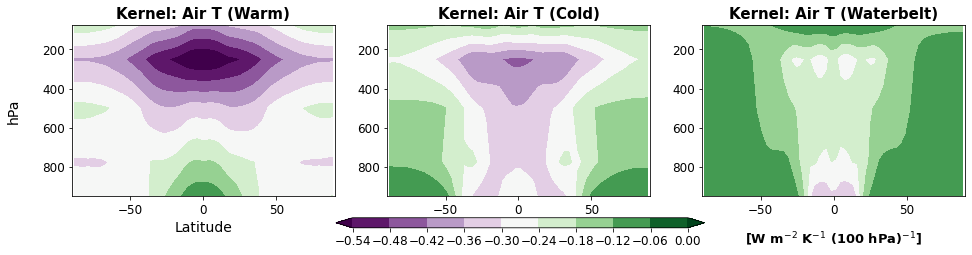

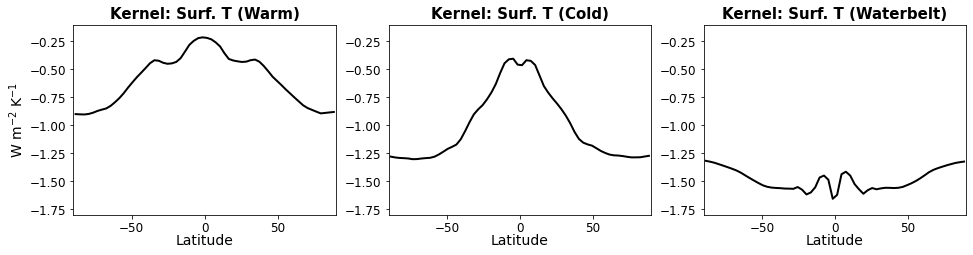

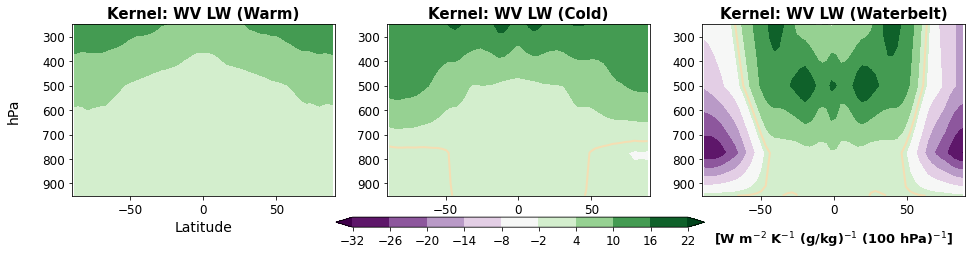

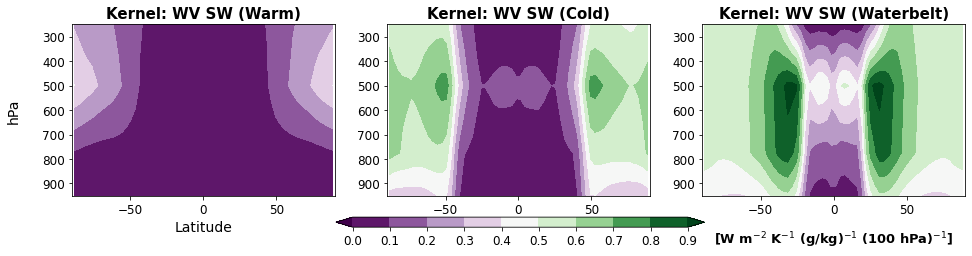

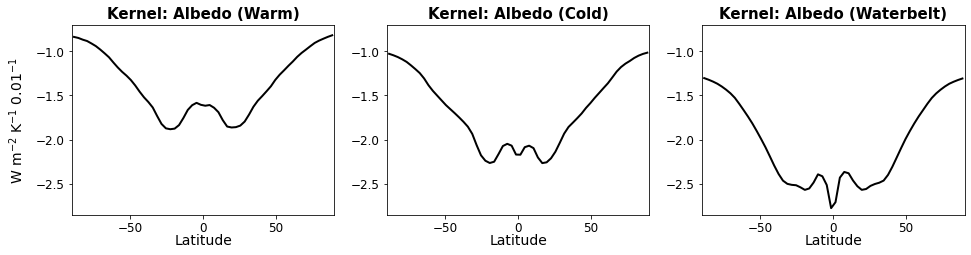

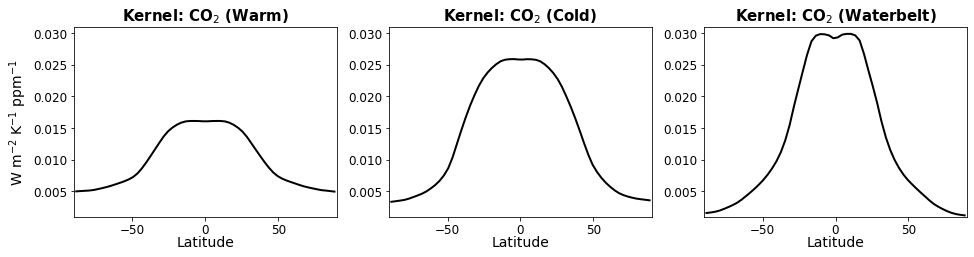

In [128]:
os.chdir('/nfs/home11/grad/2017/fz172169/0notebook')
exp = ['warm_test16_1250','cold_950','waterbelt_550']
for i in range(len(plot_kernel)):
    fig, axs = plt.subplots(1, 3, figsize=(16,3.5))
    plot_spatial_kernel(plot_kernel[i], exp)
#     fig.savefig(plot_kernel[i]+'.pdf')